In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [2]:
image_folder = "/Users/ethanweber/Documents/cARd/server/images"
image_filename = os.path.join(image_folder, "test.png")
image = cv2.cvtColor(cv2.imread(image_filename), cv2.COLOR_BGR2RGB)

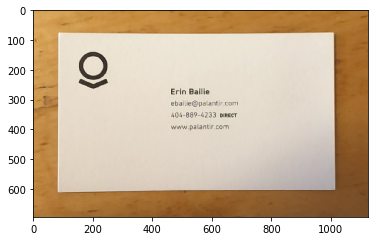

In [3]:
plt.imshow(image)

In [4]:
edges = cv2.Canny(image,100,200,apertureSize=3)

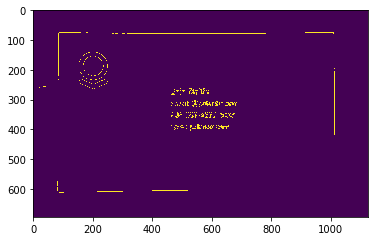

In [5]:
plt.imshow(edges)

In [6]:
lines = cv2.HoughLines(edges,1,np.pi/180,100)

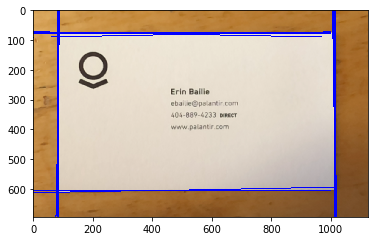

In [7]:
# draw the lines
line_image = image.copy()
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),2)
plt.imshow(line_image)

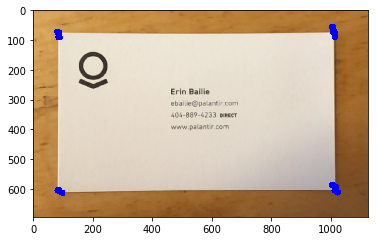

In [8]:
# find intersections in x,y space
intersection_image = image.copy()
intersections = []
# iterate over all possible intersections
for i in range(len(lines)-1):
    for j in range(i, len(lines)):
        line1 = lines[i]
        line2 = lines[j]
        rho1, theta1 = line1[0]
        rho2, theta2 = line2[0]
        
        theta_diff = abs(theta1 - theta2) % 3.14
        theta_thresh = .1
        if abs(theta_diff - 1.5707) < theta_thresh:
            x = int(rho1*np.cos(theta1) + rho2*np.cos(theta2))
            y = int(rho1*np.sin(theta1) + rho2*np.sin(theta2))
            intersections.append([x,y])
            cv2.circle(intersection_image, (x,y), 10, (0,0,255), -1)
plt.imshow(intersection_image)

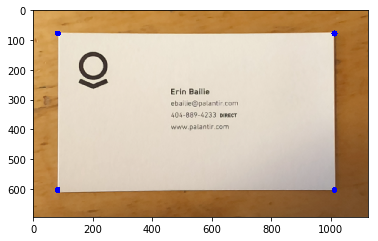

In [9]:
# do non-maximal suppression on intersections
filtered_intersection_image = image.copy()
filtered_intersections = []
# sort by x and then y
sorted_intersections = sorted(intersections)

# dictionary to maybe use key, value pairs later
used_points = {}
for i in range(len(intersections)-1):
    for j in range(i, len(intersections)):
        x1, y1 = intersections[i]
        x2, y2 = intersections[j]
        x_diff = abs(x1-x2)
        y_diff = abs(y1-y2)
        thresh = 20
        if x_diff < thresh and y_diff < thresh:
            if (x1,y1) not in used_points:
                filtered_intersections.append([x1,y1])
            used_points[(x2,y2)] = True

# draw the filtered points
for x,y in filtered_intersections:
    cv2.circle(filtered_intersection_image, (x,y), 10, (0,0,255), -1)
plt.imshow(filtered_intersection_image)


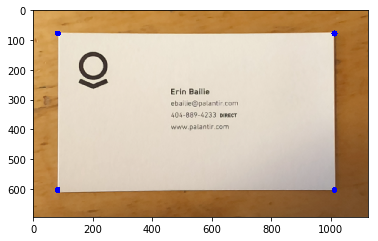

In [10]:
# find the 4 corners
final_corner_image = image.copy()
height, width = image.shape[:2]
tl, tr, bl, br = None, None, None, None
tl_min, tr_min, bl_min, br_min = None, None, None, None
for x,y in filtered_intersections:
    tl_dist = (x-0)**2 + (y-0)**2
    tr_dist = (x-width)**2 + (y-0)**2
    bl_dist = (x-0)**2 + (y-height)**2
    br_dist = (x-width)**2 + (y-height)**2
    
    # top left
    if tl_min is None or tl_dist < tl_min:
        tl = (x,y)
        tl_min = tl_dist
    
    # top right
    if tr_min is None or tr_dist < tr_min:
        tr = (x,y)
        tr_min = tr_dist
        
    # bottom left
    if bl_min is None or bl_dist < bl_min:
        bl = (x,y)
        bl_min = bl_dist
        
    # bottom right
    if br_min is None or br_dist < br_min:
        br = (x,y)
        br_min = br_dist
        
# final points
final_points = [tl, tr, bl, br]
for point in final_points:
    cv2.circle(final_corner_image, point, 10, (0,0,255), -1)
    
plt.imshow(final_corner_image)

True

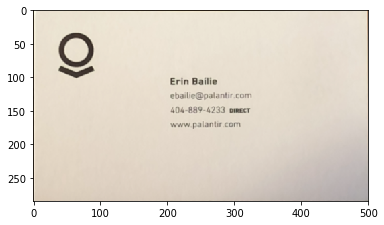

In [19]:
# card dimensions: 3.5 in x 2 in
pixel_width = 500
pixel_height = int(pixel_width*(2.0/3.5))

# compute the homography
pts_dst = [
    [0,0],
    [pixel_width,0],
    [0,pixel_height],
    [pixel_width,pixel_height]
]
h, status = cv2.findHomography(np.array(final_points), np.array(pts_dst))

im_dst = cv2.warpPerspective(image, h, (pixel_width, pixel_height))

plt.imshow(im_dst)
cv2.imwrite("imagecard.png", im_dst)